In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
import math
import os
import time

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
twoRooms_grid = two_rooms_grid(room_width=10, room_height=7, doorway_pos=3, doorway_height=1, goal_height=0)
twoRooms = GridWorld(gamma=0.95, grid=twoRooms_grid)

## Value estimation in RL

Let's define a first policy that we will test the problem with:

In [3]:
def policy1(state,GridWorld):
    if 0 in GridWorld.state_actions[state]:
        action = 0
    elif 3 in GridWorld.state_actions[state]:
        action = 3
    elif 1 in GridWorld.state_actions[state]:
        action = 1
    else:
        action = 2
    return action    

In [4]:
Q4_ValEst = ValueLearning(1,twoRooms,policy1)
Q4_ValEst.run()
Q4_ValEst.render()

## Policy learning in RL

Stats from last run
Mean reward cumulated over single episode: 2475.22


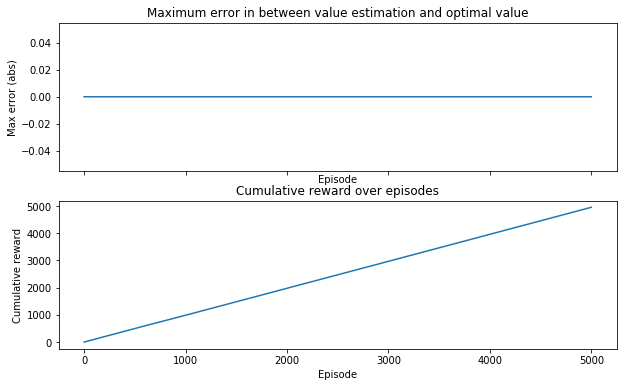

In [4]:
P = PolicyLearning(ind=0, GridWorld=twoRooms)
P.run()
P.stats()
P.render()

gui.render_policy(P.GridWorld, P.policy)

## Hierarchical RL
### MAXQ Algorithm

We will build an option $O_{downward}$ with the following characteristics:
- non-zero probability of being triggered everywhere in the left room, above the doorway
- null probability of being triggered everywhere in the right room
- when triggered, moves downward until it reaches the level of doorway, then moves right towards it
- stops when reaching the grid element just in front of the door from the left room to the right room

Similarly, we will build the $O_{upward}$ that is exactly symmetrical of $O_{downward}$, allowing to reach the doorway from every element in the lower part of the left room.

In [3]:
[downward_initSet,upward_initSet, quitMap, downward_policy_matrix, upward_policy_matrix] = two_rooms_computeOptions(room_width=10, room_height=7, doorway_pos=3, doorway_height=1)

def downward_policy(coords):
    return downward_policy_matrix[coords]
def upward_policy(state):
    return upward_policy_matrix[coords]

downward_option = Option(downward_initSet, downward_policy, quitMap, name='Downward to doorway')
upward_option = Option(upward_initSet, upward_policy, quitMap, name='Upward to doorway')

In [4]:
MaxQ_2Rooms = MAXQ(twoRooms, alpha0=0.25, n_iter=5000)

AttributeError: 'Node' object has no attribute 'option'